In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
# 绘图基础设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial'] 
plt.rcParams['axes.unicode_minus'] = False

In [19]:
# 1. 读取与清洗数据

file_path = "Final_Features_NewRules_1121.csv" 
print(f"正在读取数据: {file_path}")
df = pd.read_csv(file_path)

#特征定义
base_features = [
    'X1_SoftSeg', 'X2_DA_Content', 'X3_HardSeg', 'X4_R_Ratio', 'X5_Crosslink', 
    'DA_strategy', 'cross_class'
]
new_features = [
    'Iso_Type',  # 异氰酸酯硬度 (1-5)
    'Polyol_Type',   # 软段类型 (0-1)
    'Polyol_Mw_Score'       # 相分离程度 (0-1)
]
# 实验条件
condition_features = ['healing_temperature', 'healing_time']

# 合并所有特征列用于清洗
feature_cols = base_features + new_features + condition_features
target_cols = ['tensile_strength', 'elongation', 'healing_eff']

# 1.1 数据清洗
def clean_value(val):
    if pd.isna(val): return np.nan
    val_str = str(val)
    import re
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", val_str)
    if nums:
        return float(nums[0])
    return np.nan

# 1.2 应用清洗
cols_to_clean = feature_cols + target_cols
for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_value)

print("数据概览 (前5行):")
print(df[feature_cols + target_cols].head())
print(f"\n有效总样本数: {len(df)}")

正在读取数据: Final_Features_NewRules_1121.csv
数据概览 (前5行):
   X1_SoftSeg  X2_DA_Content  X3_HardSeg  X4_R_Ratio  X5_Crosslink  \
0        0.67            0.0        0.33        1.33      0.000000   
1        0.64            0.0        0.36        1.38      0.000000   
2        0.61            0.0        0.39        1.43      0.000000   
3        0.56            0.0        0.44        1.00      0.000246   
4        0.56            0.0        0.44        1.00      0.000246   

   DA_strategy  cross_class  Iso_Type  Polyol_Type  Polyol_Mw_Score  \
0          0.0          0.0       2.0          0.0              0.0   
1          0.0          0.0       2.0          0.0              0.0   
2          0.0          0.0       2.0          0.0              0.0   
3          0.0          0.0       2.0          0.0              0.0   
4          0.0          0.0       2.0          0.0              0.0   

   healing_temperature  healing_time  tensile_strength  elongation  \
0                100.0       

In [ ]:
# 2. 通用训练评估函数 (GPR)
def train_eval_model(task_name, target_col, input_features, data):
    # 1. 剔除该目标值缺失的样本
    df_train = data.dropna(subset=[target_col] + input_features).copy()
    
    if len(df_train) < 5:
        print(f"[{task_name}] 样本太少 ({len(df_train)}), 跳过。")
        return
    
    X = df_train[input_features].values
    y = df_train[target_col].values
    
    # 2. 数据标准化 (对 GPR 至关重要)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. 模型定义 (GPR)
    # 核函数：常数核 * RBF核 + 白噪声核 (处理实验误差)
    kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    
    # 4. 留一法交叉验证 (LOOCV)
    y_pred = cross_val_predict(model, X_scaled, y, cv=LeaveOneOut())
    
    # 5. 评估指标
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print(f"\n=== 任务: {task_name} (GPR) ===")
    print(f"使用特征数: {len(input_features)}")
    print(f"样本数: {len(y)}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    # 6. 绘图
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.7, c='royalblue', edgecolors='k')
    min_val, max_val = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel(f'Measured {target_col}')
    plt.ylabel(f'Predicted {target_col}')
    plt.title(f'{task_na㼶222222me}\nR2={r2:.2f}, RMSE={rmse:.2f}')
    plt.tight_layout()
    plt.show()

In [21]:
# 3. 特征重要性分析函数 (基于随机森林)
def analyze_feature_importance(task_name, target_col, input_features, data):
    df_train = data.dropna(subset=[target_col] + input_features).copy()
    X = df_train[input_features]
    y = df_train[target_col]
    
    # 使用随机森林查看重要性
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1] # 降序排列
    
    print(f"\n[特征重要性排行] - {task_name}")
    for i in range(len(input_features)):
        idx = indices[i]
        print(f"{i+1}. {input_features[idx]}: {importances[idx]:.4f}")
        
    # 绘图
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance for {task_name}")
    plt.bar(range(len(input_features)), importances[indices], align="center", color='teal')
    plt.xticks(range(len(input_features)), [input_features[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [22]:
# 特征组合
# 力学性能特征 = 基础配方(X1-X5) + 策略 + 新增的化学结构特征(Iso/Polyol/Mw)
features_mech = base_features + new_features
# 愈合性能特征 = 力学性能特征 + 外部条件(温度/时间)
features_heal = features_mech + condition_features
print(f"当前使用的力学特征列表: {features_mech}")

当前使用的力学特征列表: ['X1_SoftSeg', 'X2_DA_Content', 'X3_HardSeg', 'X4_R_Ratio', 'X5_Crosslink', 'DA_strategy', 'cross_class', 'Iso_Type', 'Polyol_Type', 'Polyol_Mw_Score']



=== 任务: 拉伸强度预测 (Tensile) (GPR) ===
使用特征数: 10
样本数: 90
R2 Score: 0.6077
RMSE: 8.7608


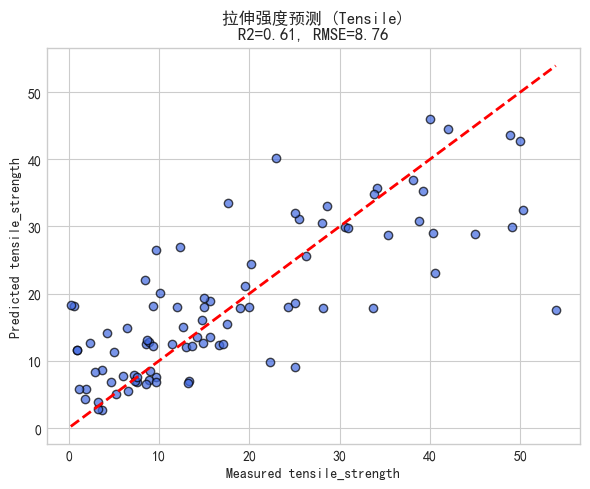


[特征重要性排行] - 拉伸强度
1. X4_R_Ratio: 0.1976
2. X5_Crosslink: 0.1741
3. Iso_Type: 0.1714
4. X1_SoftSeg: 0.1492
5. X3_HardSeg: 0.1263
6. X2_DA_Content: 0.0870
7. Polyol_Mw_Score: 0.0470
8. Polyol_Type: 0.0388
9. DA_strategy: 0.0086
10. cross_class: 0.0000


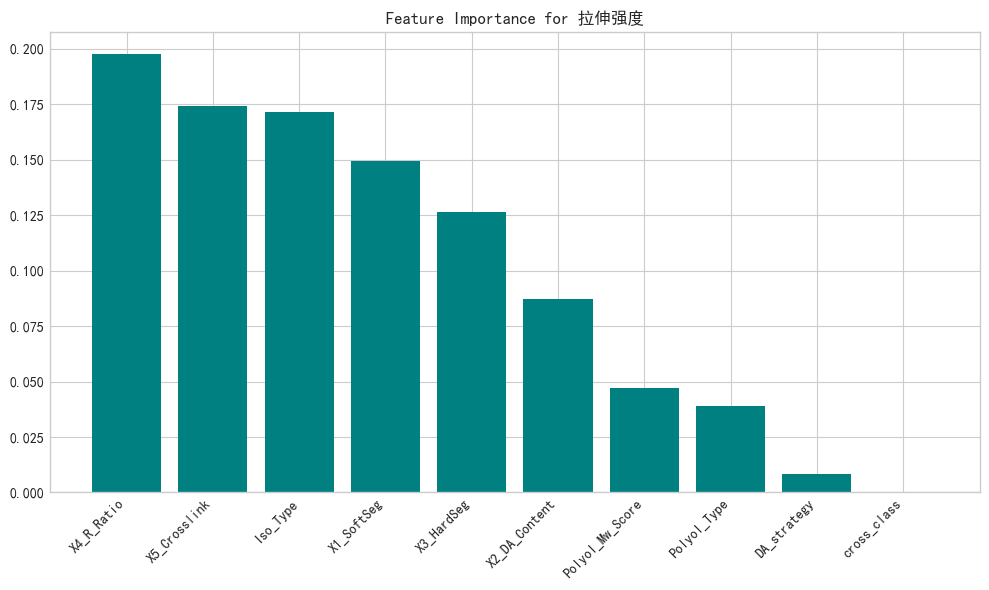


=== 任务: 断裂伸长率预测 (Elongation) (GPR) ===
使用特征数: 10
样本数: 90
R2 Score: 0.5167
RMSE: 207.8828


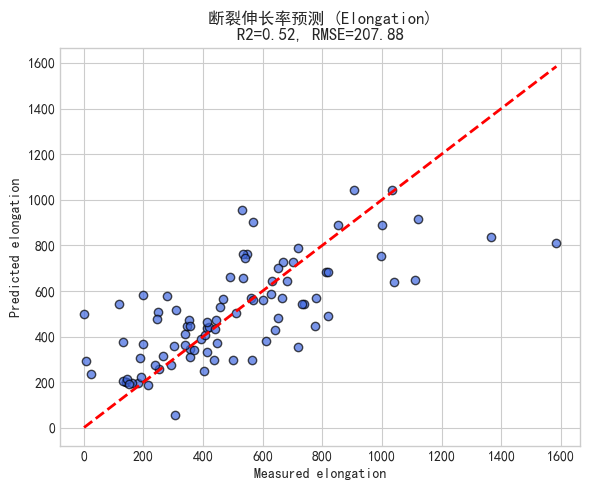


=== 任务: 自愈合效率预测 (Healing Eff) (GPR) ===
使用特征数: 12
样本数: 56
R2 Score: 0.8638
RMSE: 12.7553


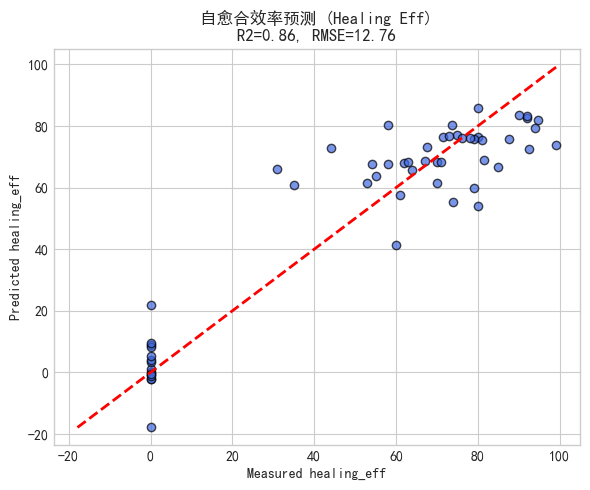

In [23]:
# 4. 执行预测任务
# 任务 A: 预测拉伸强度 (Tensile Strength)
train_eval_model("拉伸强度预测 (Tensile)", 'tensile_strength', features_mech, df)
# 顺便看一下新特征对拉伸强度的贡献
analyze_feature_importance("拉伸强度", 'tensile_strength', features_mech, df)

# 任务 B: 预测断裂伸长率 (Elongation)
train_eval_model("断裂伸长率预测 (Elongation)", 'elongation', features_mech, df)

# 任务 C: 预测自愈合效率 (Healing Efficiency)
train_eval_model("自愈合效率预测 (Healing Eff)", 'healing_eff', features_heal, df)